<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/dirichlet_Improved_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Utility.py File
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch.distributions as dist
from mpl_toolkits import mplot3d
from torch.distributions.dirichlet import Dirichlet

from scipy.stats import multivariate_normal
from scipy.stats import norm

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from scipy.stats import multivariate_normal
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

def plot_dir(alpha, size):
  model = Dirichlet(torch.tensor(alpha))
  sample = model.sample(torch.Size([size])).data
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(sample[:, 0], sample[:, 1], sample[:, 2], color='red')
  ax.plot([0, 0], [1, 0], [0, 1], linewidth=3, color='purple')
  ax.plot([0, 1], [0, 0], [1, 0], linewidth=3, color='purple')
  ax.plot([0, 1], [1, 0], [0, 0], linewidth=3, color='purple')
  ax.set_xlim((0, 1))
  ax.set_ylim((0, 1))
  ax.set_zlim((0, 1))
  ax.view_init(60, 35)


def numpy_to_tensor(arr):
  ret = torch.Tensor([arr])
  return ret

In [ ]:
def target_alpha(targets):
  target = targets.numpy()
  def gen_onehot(category, total_cat=10):
    label = np.ones(total_cat)
    label[category] = 20
    return label
  target_alphas = []
  for i in target:
    if i==10:
      target_alphas.append(torch.tensor(np.ones(10)))
    else:
      target_alphas.append(torch.tensor(gen_onehot(i)))
  return torch.stack(target_alphas)

In [ ]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x):
        
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret


In [ ]:
class PriorNet_CNN(PriorNet):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        # self.fc1 = nn.Linear(16000, 50)
        # self.fc2 = nn.Linear(50, 20)
        # self.fc3 = nn.Linear(20, 10)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.batchnormfc1 = nn.BatchNorm1d(512)
        self.batchnormfc1 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(-1, 16000)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # x = self.fc3(x)
        # return x
        x = self.batchnorm1(F.relu((self.conv1(x))))
        x = self.batchnorm2(F.relu(F.max_pool2d((self.conv2(x)), 2)))
        x = self.batchnorm3(F.relu(F.max_pool2d((self.conv3(x)), 2)))
        x = self.batchnorm4(F.relu(F.max_pool2d((self.conv4(x)), 2)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

    def fit(self, epoch_num, optimizer, train_all):
      self.train()

      # Shuffle the input
      train_loader = torch.utils.data.DataLoader(train_all, 
                                                 batch_size=32, 
                                                 shuffle=True)

      for epoch in range(epoch_num):
        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          optimizer.zero_grad()

          data = data.to(device)

          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          output_alpha = torch.exp(self.forward(data))
          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)

          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2))
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
    
    def max_prob(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values


In [ ]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)                                             
cifar_transform =  transforms.Compose(
      [transforms.ToTensor(),
     transforms.Normalize(cifar_mean, cifar_std)])

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1   = nn.Linear(16*5*5, 120)
        # self.fc2   = nn.Linear(120, 84)
        # self.fc3   = nn.Linear(84, 10)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.batchnormfc1 = nn.BatchNorm1d(512)
        self.batchnormfc1 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu((self.conv1(x))))
        x = self.batchnorm2(F.relu(F.max_pool2d((self.conv2(x)), 2)))
        x = self.batchnorm3(F.relu(F.max_pool2d((self.conv3(x)), 2)))
        x = self.batchnorm4(F.relu(F.max_pool2d((self.conv4(x)), 2)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # out = F.relu(self.conv1(x))
        # out = F.max_pool2d(out, 2)
        # out = F.relu(self.conv2(out))
        # out = F.max_pool2d(out, 2)
        # out = out.view(out.size(0), -1)
        # out = F.relu(self.fc1(out))
        # out = F.relu(self.fc2(out))
        # out = self.fc3(out)
        # return F.log_softmax(out)
        return F.log_softmax(x,dim=1)

        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = x.view(-1, 20 * 5 * 5)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # x = self.fc3(x)
        # return F.log_softmax(x)

    def fit(self, optimizer, epoch):
      train_in = torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                                      transform=cifar_transform)
      train_loader = torch.utils.data.DataLoader(train_in, batch_size=32, shuffle=True)
      self.train()
      for epoch_num in range(epoch):
        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
          optimizer.zero_grad()

          data = data.to(device)
          target = target.to(device)
            
          output = self.forward(data)
          loss = F.nll_loss(output, target)
          loss_total += loss.item()
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch_num, loss_total/120000))
        

    def test(self):
      self.eval()
      test_loss = 0
      correct = 0
      test_in_ = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                                        transform=cifar_transform)
      # print(test_in.data.shape)
      test_loader = torch.utils.data.DataLoader(test_in_, batch_size=32, shuffle=True)
      with torch.no_grad():
        for data, target in test_loader:

          data = data.to(device)
          target = target.to(device)
          output = self.forward(data)
          # print(output)
          # print(target)
          # print(data.shape)
          # print(output.shape)
          # print(target.shape)
          test_loss += F.nll_loss(output, target, size_average=False).item()
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).sum()
      test_loss /= len(test_loader.dataset)

      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
      )

    def predict_alpha(self, x):
      self.eval()
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def max_prob(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

    def entropy(self, x):
        alphas = self.predict_alpha(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret


In [ ]:
train_in = torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                                        transform=cifar_transform)

test_in = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                                        transform=cifar_transform)
train_out = torchvision.datasets.SVHN('./data', split ='train', download=True,
                                        transform=cifar_transform)
test_out = torchvision.datasets.SVHN('./data', split ='test', download=True,
                                        transform=cifar_transform)



Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
print(torch.from_numpy(train_out.data).shape)
print(torch.from_numpy(train_in.data).shape)

print(torch.from_numpy(test_out.data).shape)
print(torch.from_numpy(test_in.data).shape)

torch.Size([73257, 3, 32, 32])
torch.Size([50000, 32, 32, 3])
torch.Size([26032, 3, 32, 32])
torch.Size([10000, 32, 32, 3])


In [ ]:
train_out.data = np.vstack(train_out.data).reshape(-1, 32, 32, 3)
# test_out.data = np.vstack(test_out.data).reshape(-1, 32, 32, 3)
print(torch.from_numpy(train_out.data).shape)
print(torch.from_numpy(train_in.data).shape)

print(torch.from_numpy(test_out.data).shape)
print(torch.from_numpy(test_in.data).shape)

torch.Size([73257, 32, 32, 3])
torch.Size([50000, 32, 32, 3])
torch.Size([26032, 3, 32, 32])
torch.Size([10000, 32, 32, 3])


In [ ]:
train_in.data = torch.from_numpy(train_in.data)
train_out.data = torch.from_numpy(train_out.data)

In [ ]:
train_out.targets = torch.tensor(np.ones(len(train_out.labels))*10, dtype=torch.long)
test_out.targets = torch.tensor(np.ones(len(test_out.labels))*10, dtype=torch.long)

train_all = train_in
train_all.data = torch.cat((train_in.data, train_out.data))
train_all.targets = torch.cat((torch.IntTensor(np.array(train_in.targets)), train_out.targets)))
train_all.data = train_all.data.cpu().detach().numpy()
train_all.targets = train_all.targets.data.cpu().detach().numpy()

In [ ]:
print(train_all.data.shape)

(123257, 32, 32, 3)


In [ ]:
dpn = PriorNet_CNN()
if torch.cuda.is_available(): dpn.cuda()
optimizer = optim.Adam(dpn.parameters(), lr=0.001)

dpn.fit(30, optimizer, train_all)

Train Epoch: 0 	 Loss: 18.013435
Train Epoch: 1 	 Loss: 11.836093
Train Epoch: 2 	 Loss: 10.020044
Train Epoch: 3 	 Loss: 8.581430
Train Epoch: 4 	 Loss: 7.612537
Train Epoch: 5 	 Loss: 6.824464
Train Epoch: 6 	 Loss: 6.244492
Train Epoch: 7 	 Loss: 5.744707
Train Epoch: 8 	 Loss: 5.308050
Train Epoch: 9 	 Loss: 4.947062
Train Epoch: 10 	 Loss: 4.650488
Train Epoch: 11 	 Loss: 4.378797
Train Epoch: 12 	 Loss: 4.148765
Train Epoch: 13 	 Loss: 3.916915
Train Epoch: 14 	 Loss: 3.716497
Train Epoch: 15 	 Loss: 3.606133
Train Epoch: 16 	 Loss: 3.453809
Train Epoch: 17 	 Loss: 3.318701
Train Epoch: 18 	 Loss: 3.222665
Train Epoch: 19 	 Loss: 3.077884
Train Epoch: 20 	 Loss: 3.022358
Train Epoch: 21 	 Loss: 2.944889
Train Epoch: 22 	 Loss: 2.851599
Train Epoch: 23 	 Loss: 2.800676
Train Epoch: 24 	 Loss: 2.715148
Train Epoch: 25 	 Loss: 2.660139
Train Epoch: 26 	 Loss: 2.661542
Train Epoch: 27 	 Loss: 2.588333
Train Epoch: 28 	 Loss: 2.564966
Train Epoch: 29 	 Loss: 2.529615


In [ ]:
dnn = DNN()
if torch.cuda.is_available(): dnn.cuda()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

dnn.test()
dnn.fit(optimizer, 30)
dnn.test()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3032, Accuracy: 1000/10000 (10%)

Files already downloaded and verified
Train Epoch: 0 	 Loss: 0.016997
Train Epoch: 1 	 Loss: 0.012087
Train Epoch: 2 	 Loss: 0.010026
Train Epoch: 3 	 Loss: 0.008592
Train Epoch: 4 	 Loss: 0.007449
Train Epoch: 5 	 Loss: 0.006512
Train Epoch: 6 	 Loss: 0.005743
Train Epoch: 7 	 Loss: 0.005165
Train Epoch: 8 	 Loss: 0.004608
Train Epoch: 9 	 Loss: 0.004296
Train Epoch: 10 	 Loss: 0.003914
Train Epoch: 11 	 Loss: 0.003427
Train Epoch: 12 	 Loss: 0.003310
Train Epoch: 13 	 Loss: 0.003010
Train Epoch: 14 	 Loss: 0.002885
Train Epoch: 15 	 Loss: 0.002642
Train Epoch: 16 	 Loss: 0.002516
Train Epoch: 17 	 Loss: 0.002298
Train Epoch: 18 	 Loss: 0.002282
Train Epoch: 19 	 Loss: 0.002189
Train Epoch: 20 	 Loss: 0.002018
Train Epoch: 21 	 Loss: 0.001945
Train Epoch: 22 	 Loss: 0.001942
Train Epoch: 23 	 Loss: 0.001767
Train Epoch: 24 	 Loss: 0.001793
Train Epoch: 25 	 Loss: 0.001734
Train Epoch: 26 	 Loss: 0.001609
Train Epoch: 27 	 Loss:

In [ ]:
# train_in = torchvision.datasets.CIFAR10('/files/', train=True, download=True,
#                                         transform=cifar_transform)

# test_in = torchvision.datasets.CIFAR10('/files/', train=False, download=True,
#                                         transform=cifar_transform)
# train_out = torchvision.datasets.SVHN('./data', split ='train', download=True,
#                                         transform=cifar_transform)
# test_out = torchvision.datasets.SVHN('./data', split ='test', download=True,
#                                         transform=cifar_transform)

In [ ]:
test_in.data = np.vstack(test_in.data).reshape(-1, 3, 32, 32)
test_in.targets = torch.IntTensor(np.array(test_in.targets))

In [ ]:
print(type(test_in.targets))

<class 'torch.Tensor'>


In [ ]:
# miscood.py

def uncertainty_score(model, test_data, metrics):
  model.eval()
  score_lst = []
  for x in test_data:
    x = [x]
    with torch.no_grad():
      if metrics=='DE':
        score = model.diffenrential_entropy(x).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = model.mutual_information(x).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = model.max_prob(x).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = model.entropy(x).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(model, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
    x = [x]
    with torch.no_grad():
      pred = model.predict_alpha(x)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(test_label[i], pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  #score[score==-np.inf] = -100
  #score[score==np.inf] = 100

  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data, metrics)
  test_out_score = uncertainty_score(network, test_out.data, metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data,
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [ ]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

In [ ]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.497249,0.496140,0.496264,0.496304
AUPR,0.904678,0.904823,0.905064,0.904746


ROC curve for DPN

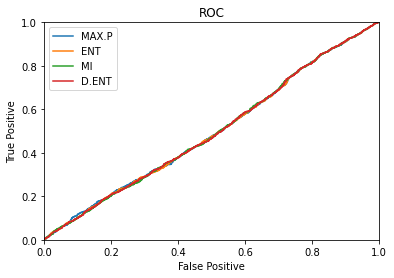

In [ ]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

Precision-Recall for DPN

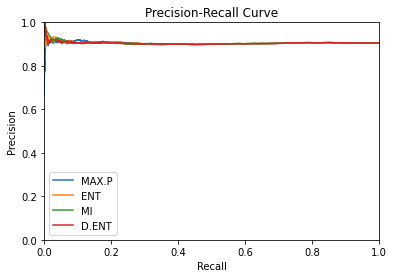

In [ ]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

**DNN**

In [ ]:
auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

auroc_lst = [auroc_mp, auroc_ent]
aupr_lst = [aupr_mp, aupr_ent]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent
AUROC,0.501848,0.509599
AUPR,0.918580,0.921924


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_name_dpn = 'dpn_cifar.pt'
path_dpn = F"/content/drive/MyDrive/{model_save_name_dpn}" 
torch.save(dpn.state_dict(), path_dpn)

Mounted at /content/drive


In [ ]:
model_save_name_dnn = 'dnn_cifar.pt'
path_dnn = F"/content/drive/MyDrive/{model_save_name_dnn}" 
torch.save(dnn.state_dict(), path_dnn)

In [ ]:
# dpn.save('/content/drive/MyDrive/dpn_entire.pt')
torch.save(dnn, '/content/drive/MyDrive/dnn_entire_cifar.pt')

In [ ]:
torch.save(dpn, '/content/drive/MyDrive/dpn_entire_cifar.pt')